# Regression(회귀): 주택가격 예측

##  보스턴 주택 가격 데이터셋
 - 전체 데이터 갯수는 506개, 404개는 훈련 샘플, 102개는 테스트 샘플로 구성됨
 - 입력 데이터에 있는 각 특성(ex. 범죄율)은 스케일(범위)가 각각 다르다.
 - 어떤 값은 0~1, 또 어떤 것은 1~12, 또는 1~100 사이의 값을 가진다.

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print('train_data shape: {0}, test_data shape: {1}'.format(train_data.shape, test_data.shape))

Using TensorFlow backend.


57344/57026 [==============================] - 2s 27us/step
train_data shape: (404, 13), test_data shape: (102, 13)


위의 출력결과에서 볼 수 있듯이404개의 훈련 샘플, 102개의 테스트 샘플이 있다.  
13개의 수치특성을 갖고 있고 이 13개의 특성은 다음과 같다.

    1. Per capita crime rate.
    2. Proportion of residential land zoned for lots over 25,000 square feet.
    3. Proportion of non-retail business acres per town.
    4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
    5. Nitric oxides concentration (parts per 10 million).
    6. Average number of rooms per dwelling.
    7. Proportion of owner-occupied units built prior to 1940.
    8. Weighted distances to five Boston employment centres.
    9. Index of accessibility to radial highways.
    10. Full-value property-tax rate per $10,000.  
    11. Pupil-teacher ratio by town.
    12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
    13. % lower status of the population.

In [2]:
# 가격은 10,000달러에서 50,000달러 사이이다. (1970년대 가격이어서 조금 저렴함..)
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 데이터 준비
 - 서로 다른 범위(스케일)를 가진 값을 신경망에 주입하면 문제가 된다.(네트워크가 다양한 데이터에 자동으로 맞추려고 할 수 있지만, 학습을 어렵게 만든다.)
 - 이런 데이터를 다룰때는 특성별로 정규화를 하는 것이 필요하다.
 - 정규화는 입력데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차를 나누는 것이다.
 - 특성의 중앙이 0근처에 맞춰지고 표준편차가 1이 된다. 넘파이를 이용하면 간단하게 할 수 있다.
 - 표준편차는 분산의 제곱근이다. numpy.std, 표준편차에 대해서는 다음url을 참고해보자.(https://code.i-harness.com/ko-kr/q/1a5254f)
 - 훈련데이터에서만 표준편차 등의 값을 구하고 있다는 것을 주목하자. 테스트 데이터의 값을 조작해서는 안된다.

In [3]:
mean = train_data.mean(axis=0)#평균 구하기
train_data -= mean#평균값을 뺀다 
std = train_data.std(axis=0)#표준편차 구하기
train_data /= std#표준편차로 나눈다.

test_data -= mean
test_data /= std

## 모델 구성
 - 샘플의 개수가 적기 때문에 64개의 유닛을 가진 두 개의 은닉층으로 네트워크를 구성해보자.  
 - 훈련데이터의 갯수가 적을 수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법이다.

In [7]:
from keras import models
from keras import layers

def build_model():
    # 동일한 모델을 여러번 생성할 것이므로 함수를 만들어 사용한다.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',\
                          input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

네트워크 구성
  - 네트워크의 마지막 층은 하나의 유닛을 갖고 있고 활성화 함수가 없다.(선형층이라고 한다.)  
  - 이것이 전형적인 스칼라 회귀(하나의 연석적인 값을 예측하는 회귀)를 위한 구성이다.  
  - 활성화 함수를 적용하면 출력값의 범위를 제한하게 된다.(예를 들어서 마지막 층에 sigmoid 활성화 함수를 적용하면 네트워크가 0과 1 사이의 값을 예측하도록 학습된다.  
  - 여기서는 마지막 층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습된다.  

mse, mae
  - 이 모델은 mse 손실함수를 사용해서 컴파일한다.  
  - 이 함수는 평균 제곱 오차(mean squared error)의 약자로 예측과 타깃 사이 거리의 제곱이다. 회귀 문제에서 널리 사용되는 손실 함수이다.  
  - 훈련하는 동안 모니터링을 위해 새로운 지표인 평균절대오차(mae)를 측정한다. 이는 예측과 타깃 사이 거리의 절댓값니다. 예를 들어 이 예제에서 MAE가 0.5이면 예측이 평균적으로 $500정도 차이가 난다는 의미이다.
  
## K-겹 검증을 사용한 훈련 검증
 - (훈련에 사용할 에포크의 수 같은) 매개변수들을 조정하면서 모델을 평가하기 위해 이전 예제에서 했던 것처럼 데이터를 훈련세트와 검증세트로 나눈다.
 - 데이터 포인트가 많지 않기 때문에 검증세트도 매우 작아진다.(약 100개의 샘플)
 - 결국 검증 세트와 훌련 세트로 어떤 데이터 포인트가 선택됐는지에 따라 검증 점수가 크게 달라지게 된다.
 - 검증세트의 분할에 대한 검증 점수의 분산이 높다. 이렇게 되면 신뢰있는 모델평가를 신뢰있게 할 수 없다.
 
 - 이런 상황에서 가장 좋은 방법은 K-겹 교차 검증을 사용하는 것이다.
 - 데이터를 K개의 분할(즉, 폴드)로 나누고(일반적으로 K=4 또는 5), K개의 모델을 각각 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법이다. 모델의 검증 점수는 K개의 검증 점수의 평균이 된다.
 
 코드로 보면 이해가 쉽다..

In [12]:
import numpy as np

k=4
num_val_samples = len(train_data) // k# 정수만 남기고 나머지는 버린다.
num_epochs = 100
all_scores = []

for i in range(k):
    print('처리 중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)* num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않는다.)
    model.fit(partial_train_data, partial_train_targets,\
             epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print('all_scores: {0}'.format(all_scores))
print('all_scores mean: {0}'.format(np.mean(all_scores)))

처리 중인 폴드 # 0
처리 중인 폴드 # 1
처리 중인 폴드 # 2
처리 중인 폴드 # 3
all_scores: [2.128112512059731, 2.3405555923386374, 2.894465642400307, 2.524274788280525]
all_scores mean: 2.4718521337698003


검증 세트가 다르므로 확실히 검증 점수가 2.0에서 2.8까지 변화가 크다. 
평균값(2.4)이 각각의 점수보다 훨씬 신뢰할 만한 점수이다. 
이것이 K-겹 교차 검증의 핵심입니다. 이 예에서는 평균적으로 3,000달러 정도 차이가 납니다. 주택 가격의 범위가 10,000달러에서 50,000달러 사이인 것을 감안하면 비교적 큰 값입니다.

신경망을 조금 더 오래 500 에포크 동안 훈련해 보죠. 각 에포크마다 모델이 얼마나 개선되는지 기록하기 위해 훈련 루프를 조금 수정해서 에포크의 검증 점수를 로그에 저장하겠습니다:


In [14]:
from keras import backend as K
# 메모리 해제
K.clear_session()

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


모든 폴드에 대해 에포크의 MAE 점수의 평균을 계산한다.

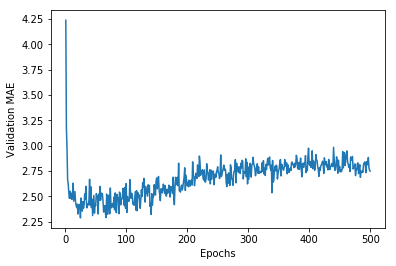

In [15]:
import matplotlib.pyplot as plt

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

그래프의 범위가 크고 변동이 심하기 때문에 보기 어렵다. 다음처럼 해보자.
 - 곡선의 다른 부분과 스케일이 많아 다른 첫 10개 데이터 포인트를 제외시킨다.
 - 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체한다.

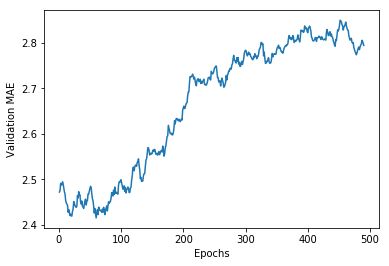

In [17]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


그래프를 보면 검증 MAE가 80번째 에포크 이후에 줄어드는 것이 멈췄다. 이 지점 이후로 과대적합이 시작된다.
모델의 다른 매개변수에 대한 튜닝이 끝나면 모든 훈련데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련시킨다. 그 다음 테스트 데이터로 성능을 확인한다.
(에포크 수 뿐만 아니라 은닉층의 크기도 조절할 수 있다.)

In [19]:
# 새롭게 컴파일된 모델을 얻는다.
model = build_model()
# 전체 데이터로 훈련시킨다.
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('test_mae_score: {0}'.format(test_mae_score))

102/102 [==============================] - 0s 929us/step
test_mae_score: 2.610782258650836


아직 2.61달러 정도 차이가 난다.


## 정리

   - 회귀는 분류에서 사용했던 것과는 다른 손실 함수를 사용합니다. 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수입니다.
   - 비슷하게 회귀에서 사용되는 평가 지표는 분류와 다릅니다. 당연히 정확도 개념은 회귀에 적용되지 않습니다. 일반적인 회귀 지표는 평균 절대 오차(MAE)입니다.
   - 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 합니다.
   - 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 신뢰있게 평가 방법입니다.
   - 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉층의 수를 줄인 모델이 좋습니다(일반적으로 하나 또는 두 개).

세 개의 예제 시리즈를 마칩니다. 이제 벡터 데이터 입력을 받는 일반적인 문제를 다룰 수 있습니다:

    이진 분류
    단일 레이블 다중 분류
    스칼라 회귀

다음 장에서 이 예제들에서 보았던 데이터 전처리, 모델 평가, 과대적합과 같은 개념에 대해 조금 더 이론적인 설명을 보완하겠습니다.